### This section is forked from and based on the code from the U of I IS559 Network Analysis by Shubhanshu Mishra: https://github.com/napsternxg/Network-Analysis-Spring-2018. To execute this file, download the file and Shubhanshu's repositories, put this file in the "notebooks" folder, and then you are good to run it.

In [4]:
%matplotlib inline

import tweepy as tw
import json
import pandas as pd
import numpy as np

from collections import defaultdict, Counter
import os
from IPython.display import clear_output

import networkx as nx


import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
from pydotplus import graph_from_dot_data
import matplotlib.image as mpimg

In [5]:
import sys
sys.path.append('../helper_libraries')
from utilities import get_statuses, get_entity_networks_from_statuses, plot_network
from utilities import get_connected_components, get_all_node_metrics, get_all_graph_metrics

In [6]:
sns.set_context("poster")
sns.set_style("ticks")

In [7]:
DATA_DIR="../data"
TWITTER_CONFIG_FILE=os.path.join(DATA_DIR, "twitter_config.json")

In [5]:
# load Twitter Access Tokens
if not os.path.isfile(TWITTER_CONFIG_FILE):
    with open(os.path.join(DATA_DIR, "twitter_config.sample.json")) as fp:
        creds = json.load(fp)
        for k in sorted(creds.keys()):
            v = input("Enter %s:\t" % k)
            creds[k] = v
    print(creds)
    with open(TWITTER_CONFIG_FILE, "w+") as fp:
        json.dump(creds, fp, indent=4, sort_keys=True)
    clear_output()
    print("Printed credentials to file %s" % TWITTER_CONFIG_FILE)

In [6]:
with open(TWITTER_CONFIG_FILE) as fp:
    creds = json.load(fp)
print(creds.keys())

dict_keys(['consumer_key', 'consumer_secret', 'access_token', 'access_token_secret'])


In [7]:
auth = tw.OAuthHandler(creds["consumer_key"], creds["consumer_secret"])
auth.set_access_token(creds["access_token"], creds["access_token_secret"])
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True,
             retry_count=5, retry_delay=100, 
            )

print("Tweepy ready for search")

Tweepy ready for search


In [8]:
users = []
num_pages=50
for i in range(num_pages):
    users.extend(api.search_users(q="urbana illinois", count=20, page=i))
len(users)

1000

In [9]:
users[0]

User(_api=<tweepy.api.API object at 0x10f273160>, _json={'id': 18165866, 'id_str': '18165866', 'name': 'Univ. of Illinois', 'screen_name': 'Illinois_Alma', 'location': 'Urbana, IL', 'description': 'All the latest from the University of Illinois at Urbana-Champaign. To thy happy children of the future, those of the past send greetings.  #ILLINOIS #ILLINI', 'url': 'http://t.co/OzoAdhZeSD', 'entities': {'url': {'urls': [{'url': 'http://t.co/OzoAdhZeSD', 'expanded_url': 'http://illinois.edu', 'display_url': 'illinois.edu', 'indices': [0, 22]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 69104, 'friends_count': 8636, 'listed_count': 933, 'created_at': 'Tue Dec 16 16:43:22 +0000 2008', 'favourites_count': 49972, 'utc_offset': -18000, 'time_zone': 'Central Time (US & Canada)', 'geo_enabled': True, 'verified': True, 'statuses_count': 33515, 'lang': 'en', 'status': {'created_at': 'Wed Apr 25 02:02:50 +0000 2018', 'id': 988961499208183809, 'id_str': '988961499208183809

In [10]:
# another way to collect users
users = []
for page_users in tw.Cursor(api.search_users, q="urbana champaign").pages(50):
    users.extend(page_users)
len(users)

1020

In [11]:
users_5000_friends = [user for user in users if user.friends_count <= 5000]
# filter the users that have more than 5000 friends, because Twitter API response would give you 5000 ids at one time
len(users_5000_friends)

1017

In [12]:
# some of the users are repetitive, we need to filter them to get the unique ones
name = [user.screen_name for user in users_5000_friends]
New_users = (set([user.id for user in users]))
len(New_users)

287

### Filtering the users that are public accounts (by hand) like "the College of Engineering", leaving only individuals, we will have 114 individuals, I have stored them at the time I get them.

In [13]:
users114 =  ['4AshleyNicole',
 'AdamBatesOrg',
 'AleRigolon',
 'AlexBartik',
 'AlexDadiet',
 'AllenRenear',
 'AndyBorstUofI',
 'BRy509',
 'BambangKhaeroni',
 'BearsFan0911',
 'BeyondtheMesas',
 'BoomlandUlti',
 'BradyHomes',
 'BrentWRoberts',
 'BrightenGodfrey',
 'CarolAmmons4IL',
 'CarpeDiemXCI',
 'DaRealD_Wade',
 'DallasTrinkle',
 'DaniBrown_KDE',
 'DarlingDae_',
 'DerekLong08',
 'DrARRob',
 'DrStrangeAnt',
 'Dr_ErdalToprak',
 'DucoLaw',
 'Editorspic',
 'EliFieldsteel',
 'Erik_theactor',
 'EsquireTheGent',
 'EstherNgumbi',
 'Fahad_AlJarboa',
 'Familyscientist',
 'H0llyw00dSmile',
 'HoosierCAB',
 'JDavis680',
 'JeremyGuest',
 'JesseMTuttle',
 'Jiajun3423',
 'JoeKryzak',
 'KarenFlynnPhD',
 'KathrynLBlum',
 'KingB921',
 'LauraFrerichs',
 'M_Montemurro',
 'MilaFuller',
 'Munehiro',
 'NWAV43',
 'Nama_Budhathoki',
 'Nicholas_Burd',
 'NikkiMcGeeFoxIL',
 'NuDelta_Zetas',
 'PresCons',
 'ReneeDeuth',
 'RobertKaz',
 'ScottKingMedia',
 'StanleyGreenJr',
 'StateRepAmmons',
 'Ted_Underwood',
 'TonyBruno',
 'TySteele_',
 'VolcanoProf',
 'Yoshi_Mori27',
 '_SilentKillerr',
 '_losimone',
 'ahmrashwan',
 'amaliafuadi',
 'ambreaxo',
 'ashmo217',
 'c_murdahh',
 'ceoshea773',
 'cernyjacob',
 'cisavesdotcom',
 'csgso',
 'dannydanr',
 'dnelll',
 'doarnold',
 'dondelelcaro',
 'dyweiss1',
 'egg_chanwich',
 'ejtheuerkauf',
 'flarnar',
 'founderprof',
 'frlampitt',
 'genopolitics',
 'geocory',
 'gorgaritonga',
 'ifoundry',
 'iguanapri',
 'imkerinfo',
 'johngwirtz',
 'kayybeear_',
 'krmcduff',
 'leakey77',
 'leal_prof',
 'lrvarshney',
 'mightyengineer',
 'mstamarrian',
 'noshfolio',
 'ntfclocal6546',
 'nuccibro',
 'pdoherty31',
 'russellmanthy',
 'rwallon',
 'ryyanmaria',
 'saramag3',
 'sergei_maslov',
 'skydrama',
 'smideros',
 'snodgrss',
 'sonnif68',
 'tin_acton',
 'tubbsjohn',
 'victoriastodden']

In [14]:
users114_friends = {user : [] for user in users114} # make a dictionary to store their friends ids

In [ ]:
# use Twitter API to get the ids for all the 114 users. However, due to some users' privacy setting, their friends data
# are uncollectible, after removing them we can finally get 108 users with their respect friend ids
for i in range(len(users114)):
    print(str(i) + ':')
    users114_friends[users114[i]] = api.friends_ids(screen_name = users114[i])

In [ ]:
# store the data for the 114 users
f = open('users114_friends','w')
for i in users114_friends:
    f.write(i + ' : ')
    f.write(str(users114_friends[i]))
    f.write('\n')
f.close()

In [ ]:
# store the data for the 108 users
f = open('users_friends','w')
for i in users_friends:
    f.write(i + ' : ')
    f.write(str(users_friends[i]))
    f.write('\n')
f.close()

In [24]:
# read data from the file above
f = open('users_friends','r')
users_friends = {}
users_friends_str = f.readlines()
for user in users_friends_str:
    user_ids_str = user.split()
    user_ids_str[2] = user_ids_str[2].replace('[','')
    user_ids_str[-1] = user_ids_str[-1].replace(']','')
    users_friends[user_ids_str[0]] = [int(friend_id.replace(',','')) for friend_id in user_ids_str[2::]]
len(users_friends)

108

In [25]:
# get the nodes for the first graph
nodes_1 = list(users_friends.keys())

In [26]:
# start building the first graph, which is friendship network (directed)
G1 = nx.DiGraph()

In [9]:
# add all the nodes_1 to graph G1
G1.add_nodes_from(nodes_1)

In [62]:
# make pairs for users with their screen_names and ids
nodes_ids = {user.screen_name : user.id for user in users if user.screen_name in nodes_1}
nodes_ids

{'4AshleyNicole': 1623461150,
 'AdamBatesOrg': 3377581787,
 'AleRigolon': 134023690,
 'AlexBartik': 18345202,
 'AllenRenear': 20413677,
 'AndyBorstUofI': 47986003,
 'BRy509': 218575202,
 'BambangKhaeroni': 2467455876,
 'BearsFan0911': 58681858,
 'BeyondtheMesas': 409314032,
 'BoomlandUlti': 269398467,
 'BradyHomes': 40011564,
 'BrentWRoberts': 1618123446,
 'BrightenGodfrey': 4922653278,
 'CarolAmmons4IL': 1945342142,
 'DaRealD_Wade': 253339190,
 'DallasTrinkle': 229719855,
 'DaniBrown_KDE': 171735270,
 'DerekLong08': 47488535,
 'DrStrangeAnt': 4833277564,
 'Dr_ErdalToprak': 3239165174,
 'DucoLaw': 78937963,
 'Editorspic': 33432027,
 'EliFieldsteel': 116069873,
 'Erik_theactor': 135935957,
 'EsquireTheGent': 43805717,
 'EstherNgumbi': 359037337,
 'Fahad_AlJarboa': 104805338,
 'Familyscientist': 2510124716,
 'H0llyw00dSmile': 24305574,
 'HoosierCAB': 15280125,
 'JDavis680': 974731033,
 'JeremyGuest': 1425700225,
 'JesseMTuttle': 778263470,
 'Jiajun3423': 708526898,
 'KarenFlynnPhD': 5815

In [74]:
# save the 108 pairs as well
f = open('users_ids','w')
for i in nodes_ids:
    f.write(i + ' : ')
    f.write(str(nodes_ids[i]))
    f.write('\n')
f.close()

In [47]:
# read the users_ids data
f = open('users_ids','r')
nodes_ids = {}
nodes_ids_str = f.readlines()
for user in nodes_ids_str:
    user_id_str = user.split()
    nodes_ids[user_id_str[0]] = int(user_id_str[2])
len(nodes_ids)

108

In [48]:
nodes_ids

{'4AshleyNicole': 1623461150,
 'AdamBatesOrg': 3377581787,
 'AleRigolon': 134023690,
 'AlexBartik': 18345202,
 'AlexDadiet': 62444070,
 'AllenRenear': 20413677,
 'AndyBorstUofI': 47986003,
 'BRy509': 218575202,
 'BambangKhaeroni': 2467455876,
 'BearsFan0911': 58681858,
 'BeyondtheMesas': 409314032,
 'BoomlandUlti': 269398467,
 'BradyHomes': 40011564,
 'BrentWRoberts': 1618123446,
 'BrightenGodfrey': 4922653278,
 'CarolAmmons4IL': 1945342142,
 'DaRealD_Wade': 253339190,
 'DallasTrinkle': 229719855,
 'DaniBrown_KDE': 171735270,
 'DerekLong08': 47488535,
 'DrARRob': 3301268434,
 'DrStrangeAnt': 4833277564,
 'Dr_ErdalToprak': 3239165174,
 'DucoLaw': 78937963,
 'Editorspic': 33432027,
 'EliFieldsteel': 116069873,
 'Erik_theactor': 135935957,
 'EsquireTheGent': 43805717,
 'EstherNgumbi': 359037337,
 'Fahad_AlJarboa': 104805338,
 'Familyscientist': 2510124716,
 'H0llyw00dSmile': 24305574,
 'HoosierCAB': 15280125,
 'JDavis680': 974731033,
 'JeremyGuest': 1425700225,
 'JesseMTuttle': 778263470,

In [49]:
for user_A in users_friends:
    for user_B in users_friends:
        if nodes_ids[user_A] in users_friends[user_B]:
            G1.add_edge(user_A, user_B)

In [80]:
G1.size()

114

(-1.0987084161251701,
 0.92398209180748969,
 -0.82567727352168352,
 1.1734806459002505)

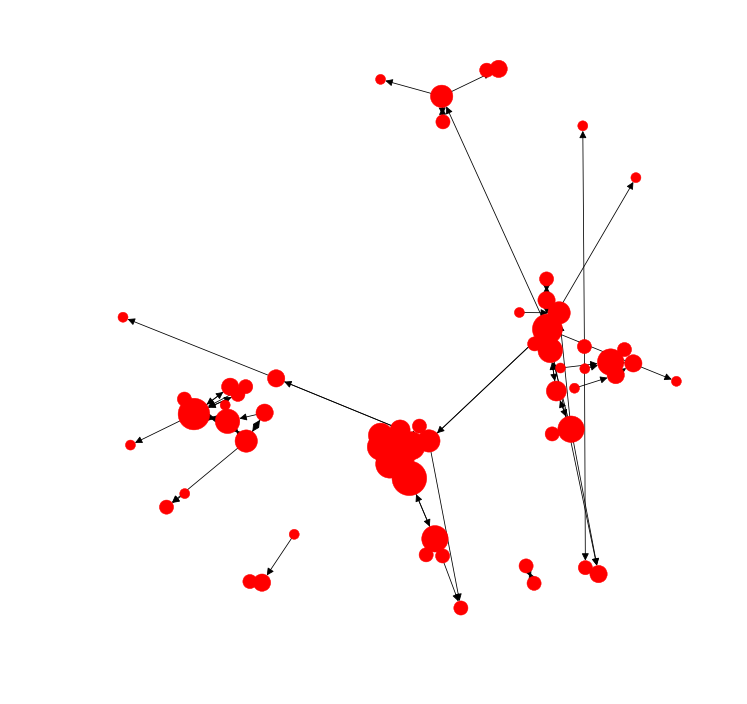

In [88]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))
nx.draw_networkx(
    G1, with_labels=False,
    node_size=[x[1]*100 for x in G1.degree()],
    pos=nx.spring_layout(G1),
    width=0.8,
    arrowsize = 15,
    ax=ax
)
ax.axis("off")

In [54]:
strong_connected_components = sorted(
    nx.strongly_connected_component_subgraphs(G1),
    key = lambda gs: len(gs.nodes()),
    reverse=True)
print("{} strong connected components found.".format(len(strong_connected_components)))

30 strong connected components found.


(-0.50512528192473993,
 0.6049444719436301,
 -0.8455846397846607,
 1.1753722960881352)

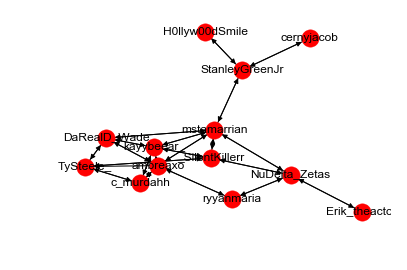

In [55]:
fig, ax = plt.subplots(1,1)
nx.draw_networkx(strong_connected_components[0])
ax.axis("off")

(-0.77440102064273608,
 0.81281151064821655,
 -0.76932594774325558,
 1.1681259950344272)

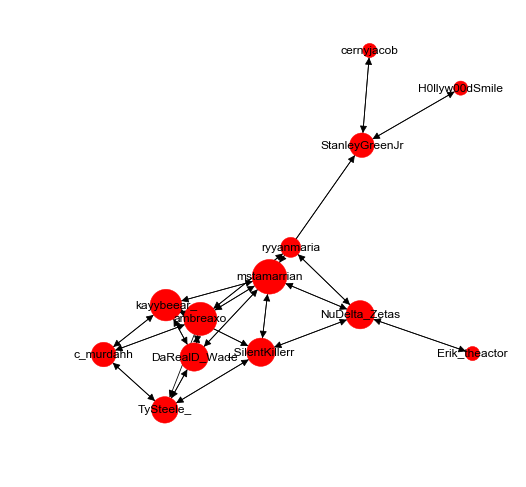

In [86]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
nx.draw_networkx(
    strong_connected_components[0], with_labels=True,
    node_size=[x[1]*100 for x in strong_connected_components[0].degree()],
    pos=nx.spring_layout(strong_connected_components[0]),
    width=0.8,
    arrowsize = 15,
    ax=ax
)
ax.axis("off")

In [86]:
df_graph_metrics = get_all_graph_metrics(strong_connected_components[0].to_undirected())
df_graph_metrics

,values
avg. path length,2.192308
clustering coefficents,0.261538
density,0.282051
transitivity,0.380282
connected components,1.000000
diameter,4.000000
radius,2.000000


In [58]:
weak_connected_components = sorted(
    nx.weakly_connected_component_subgraphs(G1),
    key = lambda gs: len(gs.nodes()),
    reverse=True)
print("{} weak connected components found.".format(len(weak_connected_components)))

5 weak connected components found.


In [126]:
# make the second graph to find communities of interests
G2 = nx.Graph()
G2.add_nodes_from(nodes_1)

(-0.91240022811696841,
 0.80576038676280237,
 -1.1768689931563225,
 0.861335594645108)

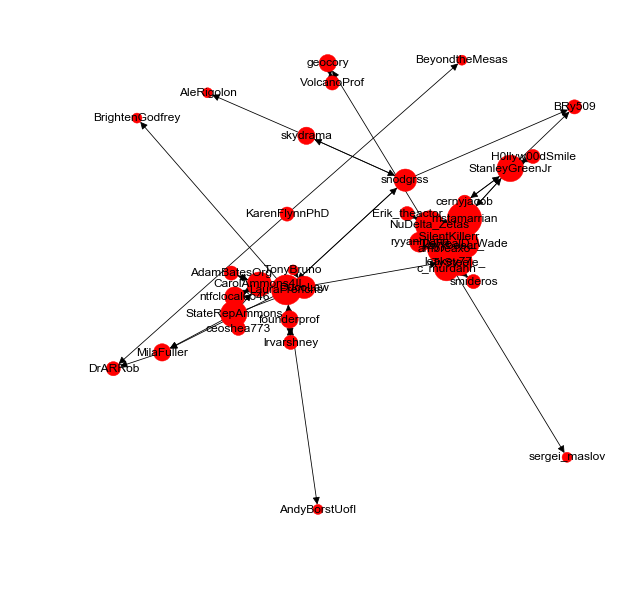

In [93]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
nx.draw_networkx(
    weak_connected_components[0], with_labels=True,
    node_size=[x[1]*100 for x in weak_connected_components[0].degree()],
    arrowsize = 15,
    pos=nx.spring_layout(weak_connected_components[0]),
    width=0.8,
    ax=ax
)
ax.axis("off")

In [108]:
len(G1.degree())

62

In [102]:
degree = {}
for i in [i for i in G1.degree()]:
    if i[1] in degree:
        degree[i[1]] += 1
    else:
        degree[i[1]] = 1

In [109]:
degree[0] = 108 - 62

In [121]:
import matplotlib.ticker

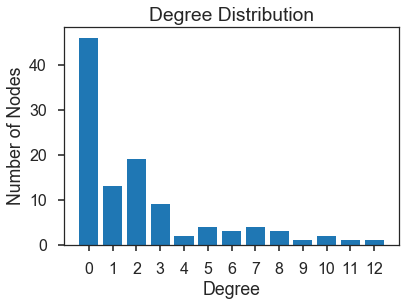

In [126]:
plt.bar(list(degree.keys()), degree.values())
plt.xticks(list(degree.keys()), [str(i) for i in list(degree.keys())])
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution')

In [133]:
ud = strong_connected_components[0].to_undirected()

In [151]:
f = open('centrality', 'w')
for i in sorted(nx.clustering(ud).items(), key = lambda item : item[1], reverse = True):
    f.write(str(i))
    f.write('\n')

In [144]:
nx.average_shortest_path_length(weak_connected_components[0])

0.7183499288762447

### To make the second network for finding communities of interests, we set a threshold of 30: if two users follow more than 30 common account, we regard them as similar and add an edge between them.

In [152]:
# make a dictionary of all the people's friends, and theirs percentage of the numbers of followers to 108
friends_followers = {}
for user in users_friends:
    for friend in users_friends[user]:
        if friend in friends_followers:
            friends_followers[friend] += 1
        else:
             friends_followers[friend] = 1

In [172]:
followed_users = sorted(friends_followers.items(), key = lambda item : item[1], reverse = True)

In [154]:
s = sorted([len(i[1]) for i in list(users_friends.items())])

In [175]:
s = [i[1] for i in followed_users]

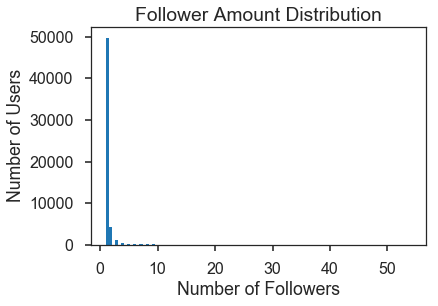

In [184]:
plt.hist(s, bins = 100)
plt.xlabel('Number of Followers')
plt.ylabel('Number of Users')
plt.title('Follower Amount Distribution')

In [156]:
G2 = nx.Graph()

In [218]:
len(nodes_1)

108

In [157]:
for user_A in users_friends:
    for user_B in users_friends:
        if len(set(users_friends[user_A]) & set(users_friends[user_B])) > 29:
            G2.add_edge(user_A, user_B)

In [216]:
f = open('pairs.csv','w')
for user_A in users_friends:
    for user_B in users_friends:
        if len(set(users_friends[user_A]) & set(users_friends[user_B])) > 29:
            f.write(user_A + ',' + user_B)
            f.write('\n')

In [221]:
f = open('pairs.csv','w')
for i in range(len(users_friends) - 1):
    user_A = users_names[i]
    for j in range(i + 1, len(users_friends)):
        user_B = users_names[j]
        if len(set(users_friends[user_A]) & set(users_friends[user_B])) > 29:
            f.write(user_A + ',' + user_B)
            f.write('\n')

(-1.1047293484933323,
 1.0826687271177491,
 -1.1089517191165044,
 1.0689307426894881)

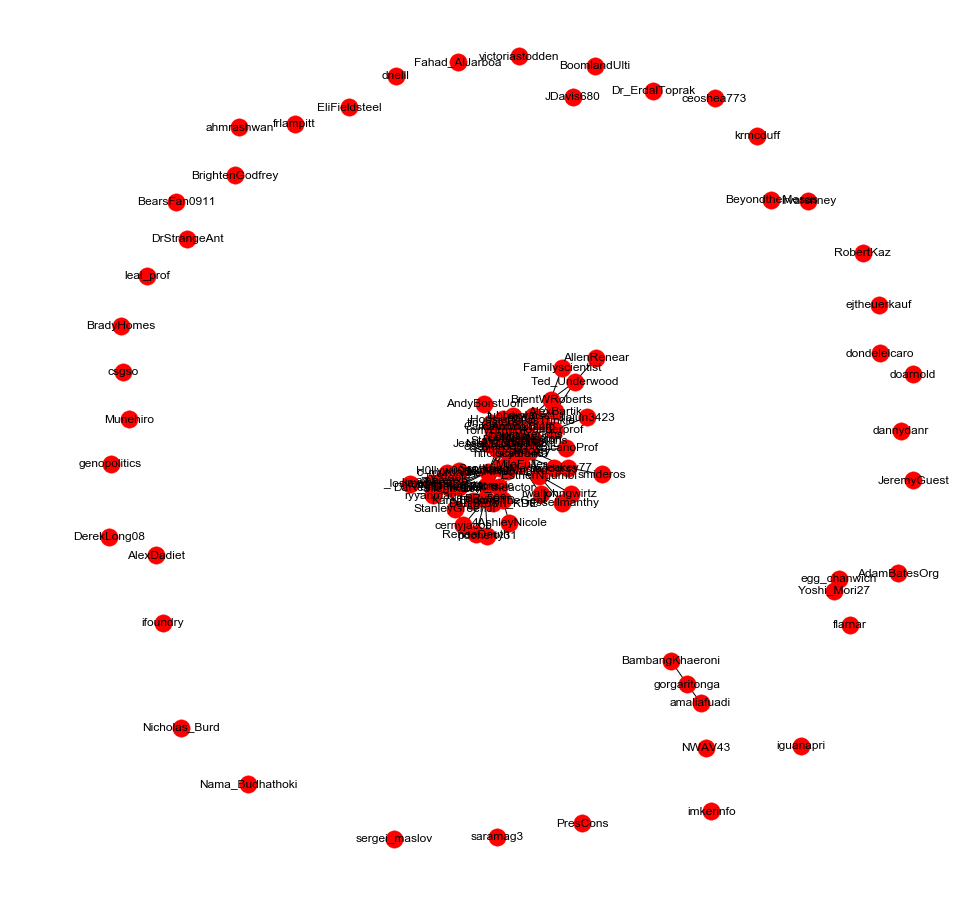

In [129]:
fig, ax = plt.subplots(1,1, figsize=(16, 16))
nx.draw_networkx(G2)
ax.axis("off")

In [158]:
connected_components = sorted(nx.connected_component_subgraphs(G2), key = len, reverse=True)
print("{} connected components found.".format(len(connected_components)))

39 connected components found.


In [204]:
f = open('centrality', 'w')
for i in sorted(nx.eigenvector_centrality(connected_components[0]).items(), key = lambda item : item[1], reverse = True):
    f.write(str(i))
    f.write('\n')

(-0.88632762562424117,
 1.0999871401364301,
 -0.88245914884515808,
 0.88983707113905219)

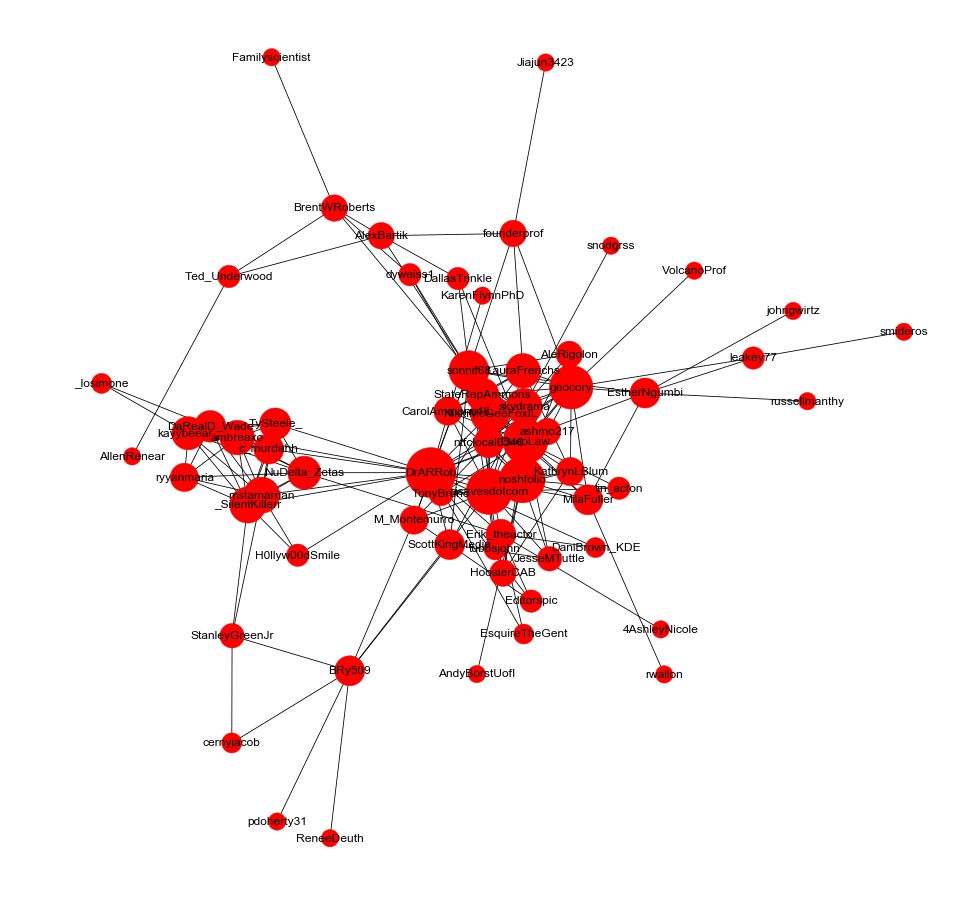

In [161]:
fig, ax = plt.subplots(1,1, figsize=(16, 16))
nx.draw_networkx(
    connected_components[0], with_labels=True,
    node_size=[x[1]*100 for x in connected_components[0].degree()],
    pos=nx.spring_layout(connected_components[0]),
    width=0.8,
    ax=ax
)
ax.axis("off")

### We want to know if mutual friends share more interests than those are not friends, we make a interest similarity metric, which is, for those are mutual friends: the intersection of theirs friends / (the union of their friends - 2), because when need to remove them from their friend list, for those who are not friends mutually, but one follows another: the intersection of theirs friends / the union of their friends - 1, and for those who do not have any relationship: the intersection of theirs friends / the union of their friends.

In [205]:
similarity_mutual_friends_sum = 0
mutual_friends_num = 0
similarity_one_friend_sum = 0
one_friend_num = 0
similarity_no_relationship_sum = 0
no_relationship_num = 0
users_names = list(users_friends.keys())
users_num = len(users_names)
for i in range(users_num - 1):
    user_A = users_names[i]
    for j in range(i + 1, users_num):
        user_B = users_names[j]
        intersection = len(set(users_friends[user_A]) & set(users_friends[user_B]))
        union = len(set(users_friends[user_A]) | set(users_friends[user_B]))
        if nodes_ids[user_A] in users_friends[user_B] and nodes_ids[user_B] in users_friends[user_A]:
            mutual_friends_num += 1
            similarity_mutual_friends_sum += intersection / (union - 2)
        elif nodes_ids[user_A] not in users_friends[user_B] and nodes_ids[user_B] not in users_friends[user_A]:
            no_relationship_num += 1
            similarity_no_relationship_sum += intersection / union
        else:
            one_friend_num += 1
            similarity_one_friend_sum += intersection / (union - 1)

In [206]:
similarity_mutual_friends_avg = similarity_mutual_friends_sum / mutual_friends_num
similarity_one_friend_avg = similarity_one_friend_sum / one_friend_num
similarity_no_relationship_avg = similarity_no_relationship_sum / no_relationship_num
print("The average similarity for those who are mutual friends is {} .".format(similarity_mutual_friends_avg))
print("The average similarity for those where one follows another but not vice versa is {} .".format(similarity_one_friend_avg))
print("The average similarity for those who have no relationship is {} .".format(similarity_no_relationship_avg))

The average similarity for those who are mutual friends is 0.05187572214989332 .
The average similarity for those where one follows another but not vice versa is 0.027846685446290716 .
The average similarity for those who have no relationship is 0.0037311474348029855 .
